In [936]:
# !pip install --upgrade pip
# !pip install gymnasium
# !pip install optuna

In [140]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import matplotlib.animation as animation
import time
import optuna

# Creating RaceTrack Environment

In [141]:
class RaceEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    action = 0
    def __init__(self):
        self.observation_space = spaces.Discrete(100)
        self.action_space = spaces.Discrete(4)
        self.agent_pos = [9, 0]
        self.goal_pos = [6, 6]
  
        self.state = np.array([
            [-1,-1,0,0,0,0,0,-1,-1,-1],
            [-1,-1,0,0,0,0,0,-1,-1,-1],
            [-1,-1,0,0,-10,0,0,-1,-1,-1],
            [-1,-1,0,0,-10,0,0,-1,-1,-1],
            [-1,-1,0,0,-10,0,0,-1,-1,-1],
            [-1,-1,0,0,-10,0,0,-1,-1,-1],
            [-1,-1,0,0,-10,0,10,-1,-1,-1],
            [-1,-1,0,0,-10,-1,-1,-1,-1,-1],
            [-1,-1,0,0,-10,-1,-1,-1,-1,-1],
            [0,0,0,0,-10,-1,-1,-1,-1,-1]
        ])

    def reset(self):

        self.agent_pos = [9, 0]
        observation = self.state.flatten()
        return observation

    def step(self, action):
        self.action = action
        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, 9)

        observation = self.state.flatten()
        
        reward = self.state[tuple(self.agent_pos)]
        
        return observation, reward

    def render(self):
        plt.imshow(self.state)
        plt.text(self.agent_pos[1],self.agent_pos[0],'X')
        plt.pause(1)
        
        
  


# Creating Car Agent

In [142]:
class CarAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
  def step(self, obs):
    return np.random.choice(self.action_space.n)

# Making Car to move 10 Steps

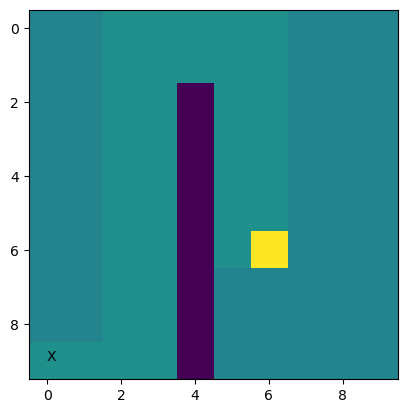

State(9, 0)
Action : 0 Reward : 0


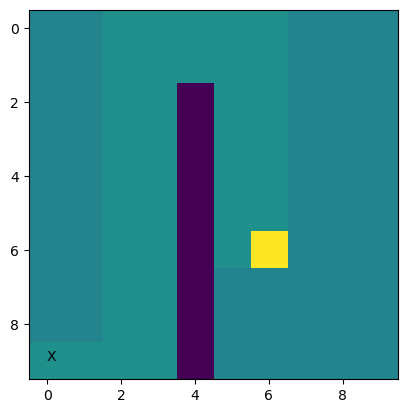

State(9, 0)
Action : 3 Reward : 0


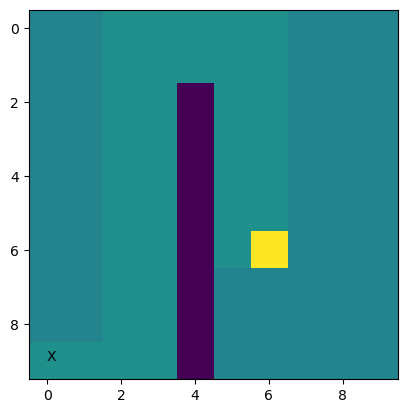

State(9, 0)
Action : 3 Reward : 0


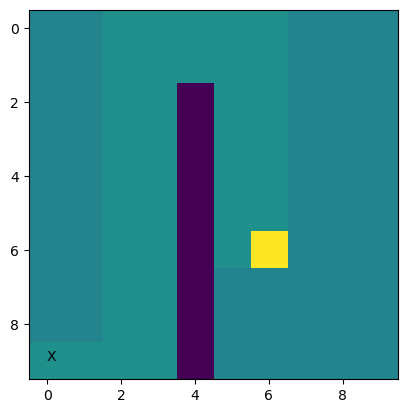

State(9, 0)
Action : 0 Reward : 0


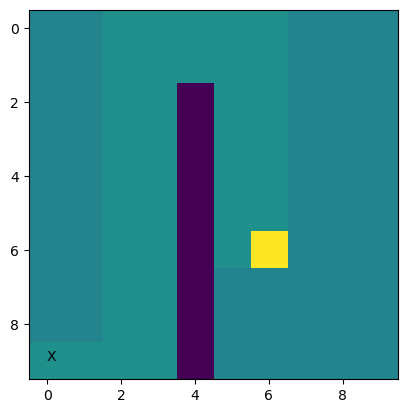

State(9, 1)
Action : 2 Reward : 0


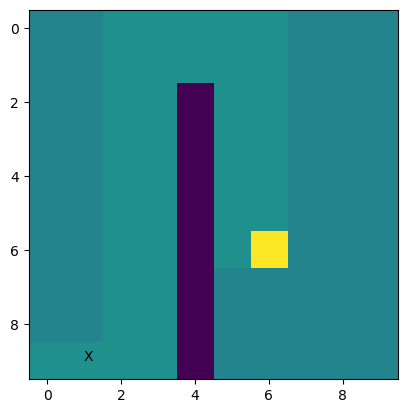

State(8, 1)
Action : 1 Reward : -1


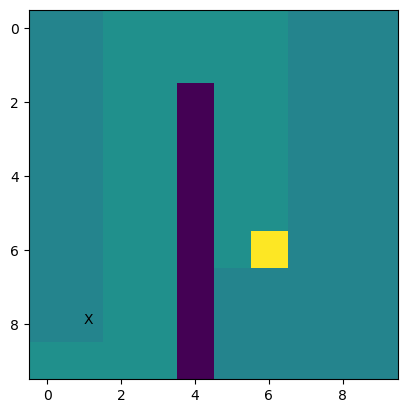

State(7, 1)
Action : 1 Reward : -1


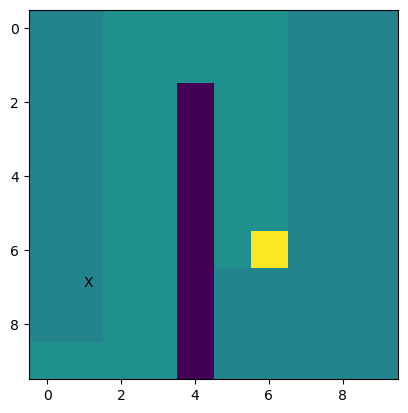

State(6, 1)
Action : 1 Reward : -1


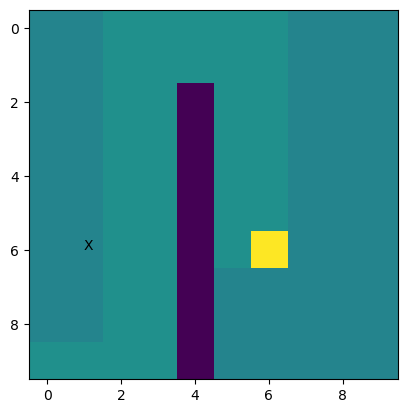

State(5, 1)
Action : 1 Reward : -1


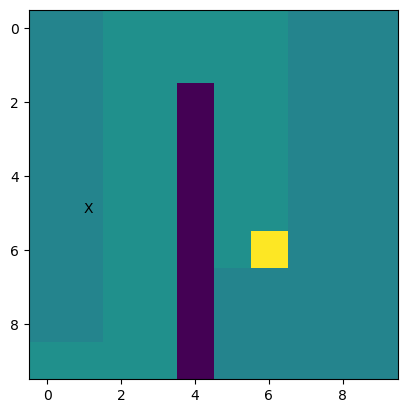

State(6, 1)
Action : 0 Reward : -1


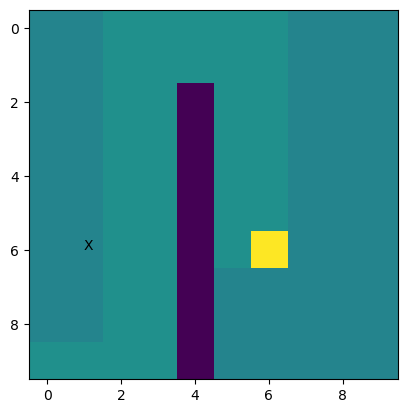

In [143]:
race = RaceEnv()
agent = CarAgent(race)
obs = race.reset()
race.render()
for _ in range(10):
    obs, reward = race.step(agent.step(obs))
    print(f'State({race.agent_pos[0] }, {race.agent_pos[1] })')
    print(f'Action : {race.action} Reward : {reward}')
    race.render()

# Creating a Function named SARSA to perform SARSA

In [145]:
def SARSA(total_episodes,Environment,Agent,minEpsilon,epsilon,Steps,alpha,discountFactor,decayRate,greedy = False):
  table =[[[0 for i in range(4)] for j in range(10)] for k in range(10)]
  rewards = []
  epsilons = []
  timesteps = []
  race = Environment()
  agent = Agent(race)
  for present_episode in range(1,total_episodes+1):
    reward = 0
    obs = race.reset()
    action = agent.step(obs) if np.random.uniform(0,1) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
    
    if greedy:
      i = 0
      while not all(race.agent_pos == np.array(race.goal_pos)):
        arg1 = race.agent_pos[0]
        arg2 = race.agent_pos[1]
        observation,reward_by_step = race.step(action)
        reward += reward_by_step
        action_next = agent.step(obs) if np.random.uniform(0,1) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
        table[arg1][arg2][action] += alpha * (reward_by_step + discountFactor * (table[race.agent_pos[0]][race.agent_pos[1]][action_next]) - table[arg1][arg2][action])
        action = action_next
        i += 1
      timesteps.append(i)
    else:
      i = 0
      for _ in range(Steps):
        arg1 = race.agent_pos[0]
        arg2 = race.agent_pos[1]
        observation,reward_by_step = race.step(action)
        reward += reward_by_step
        action_next = agent.step(obs) if np.random.uniform(0,1) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
        table[arg1][arg2][action] += alpha * (reward_by_step + discountFactor * (table[race.agent_pos[0]][race.agent_pos[1]][action_next]) - table[arg1][arg2][action])
        i += 1
        if all(race.agent_pos == np.array(race.goal_pos)):
          break
        action = action_next
      timesteps.append(i)
    epsilons.append(epsilon)
    epsilon = max(minEpsilon, (np.exp(-decayRate*present_episode)))
    rewards.append(reward)
  return table,rewards,epsilons,timesteps

# Creating QTable_df function convert the Qtable into a neat DataFrame looking Structure

In [146]:
def QTable_df(QTable):
  df = pd.DataFrame({})
  for i in range(len(QTable)):
    for j in range(len(QTable[i])):
      state = f'State ({i},{j})'
      df[state] = QTable[i][j]
  return df

# Performing Hypertuning on Parameter Alpha,Discount Factor

# HyperTuning Alpha

# 1

In [147]:
episodes =4000
steps = 25
alpha = 0.1
discountFactor = 0.99
decayRate = 0.004
maxEpsilon = 1
minEpsilon = 0

In [148]:
SARSA1_QTable,SARSA1_Rewards,SARSA1_Epsilon,SARSA1_timesteps = SARSA(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(SARSA1_QTable)


,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.298720,-0.509177,-0.122702,2.243921,1.615465,9.414801,5.744830,-0.100000,-0.10,-0.1,...,0.025399,1.219203,1.052071,-2.560906,-5.052875,-0.714621,-0.339841,-0.190000,-0.100000,-0.19
1,-0.390526,-0.100000,-0.130801,2.958297,3.593102,4.931814,-0.035889,-0.100000,-0.19,0.0,...,-2.162590,-1.188600,8.345138,-1.562364,-6.661200,-1.239906,-0.628125,-0.229453,-0.190000,-0.19
2,-0.367016,-0.055660,5.212453,9.227447,9.320653,1.233411,-0.529318,-0.190000,-0.10,0.0,...,8.179069,8.261686,-1.316675,-10.969324,-1.606572,-0.735197,-0.503585,-0.353800,-0.100000,-0.10
3,-0.299700,-0.472281,-1.017878,0.686567,3.629747,3.679579,-0.025027,0.037848,0.00,0.0,...,-0.057170,2.451655,0.598779,-0.204630,-2.610261,-3.009299,-0.295599,-0.213773,-0.126829,-0.10


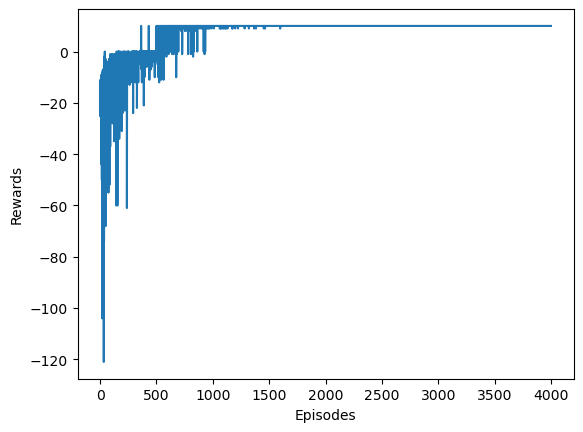

In [149]:
plt.plot(range(len(SARSA1_Rewards)),SARSA1_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

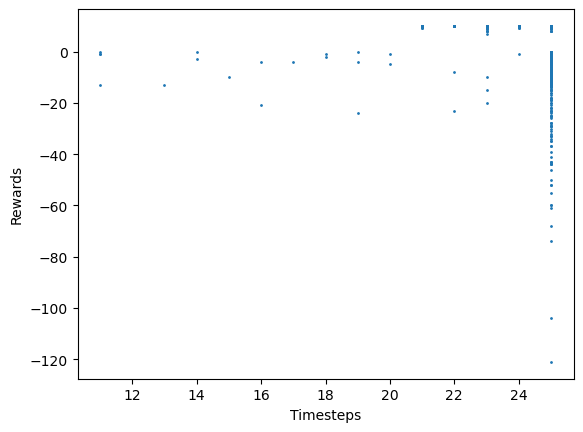

In [152]:
temp = sorted(zip(SARSA1_Rewards,SARSA1_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

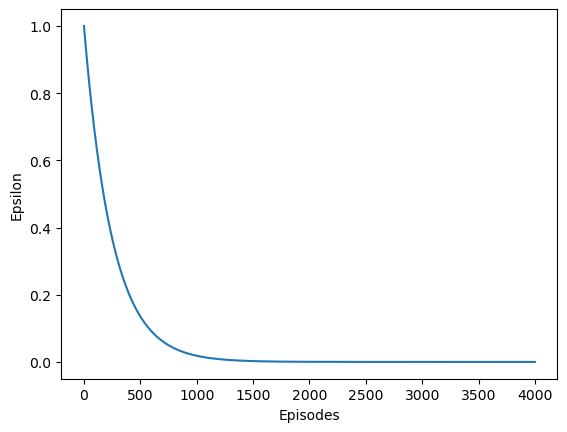

In [151]:
plt.plot(range(len(SARSA1_Rewards)),SARSA1_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# 2 

In [153]:
episodes =4000
steps = 25
alpha = 0.01
discountFactor = 0.99
decayRate = 0.004
maxEpsilon = 1
minEpsilon = 0

In [154]:
SARSA2_QTable,SARSA2_Rewards,SARSA2_Epsilon,SARSA2_timesteps = SARSA(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(SARSA2_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.010099,-1.999994e-02,-0.000099,-0.000153,-0.004661,-0.000031,-0.000195,-2.970100e-02,0,0,...,-0.144717,-0.105199,-0.097826,-0.096681,-0.877151,-0.094629,-0.039890,-0.020097,-0.029701,-0.019900
1,0.000000,-1.999998e-02,-0.000393,-0.000003,-0.000056,-0.000019,-0.000100,-2.009701e-02,0,0,...,-0.920643,-0.808543,-0.000010,-0.067958,-0.973386,-0.072980,-0.050048,-0.019900,0.000000,-0.010000
2,0.000000,-2.151337e-07,-0.000057,-0.000112,-0.000014,-0.000470,-0.039500,-1.000000e-02,0,0,...,-0.000013,-0.000011,-0.289664,-3.571334,-0.127652,-0.097743,-0.049304,-0.039698,-0.019900,-0.019900
3,0.000000,-1.000000e-02,-0.058520,-0.000133,-0.000015,-0.000043,-0.000002,-1.972199e-08,0,0,...,-0.145834,-0.116826,-0.111216,-0.054724,-0.117189,-0.588263,-0.041543,-0.010000,-0.010000,-0.010197


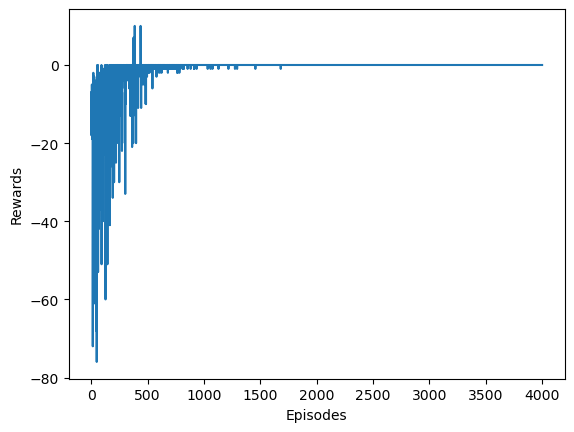

In [155]:
plt.plot(range(len(SARSA2_Rewards)),SARSA2_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

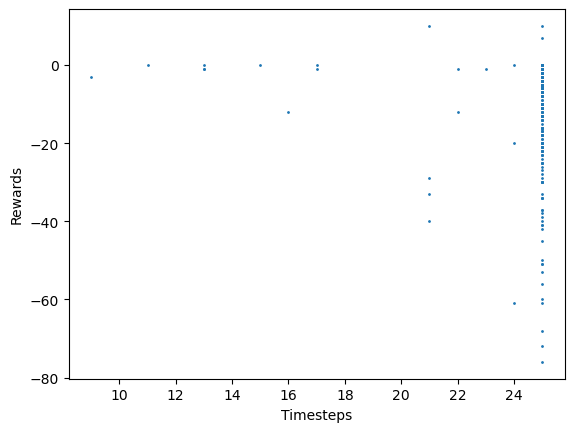

In [156]:
temp = sorted(zip(SARSA2_Rewards,SARSA2_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

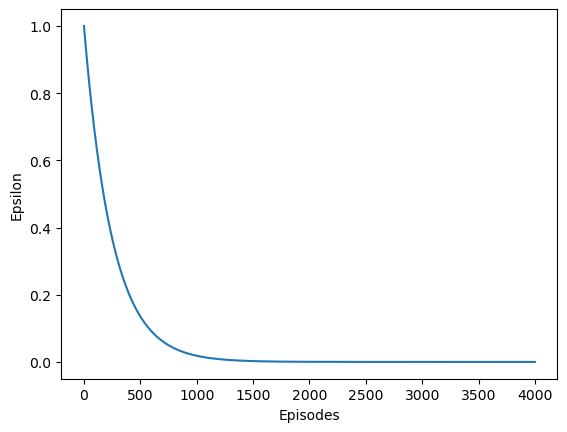

In [157]:
plt.plot(range(len(SARSA2_Epsilon)),SARSA2_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# 3

In [158]:
episodes =4000
steps = 25
alpha = 1
discountFactor = 0.99
decayRate = 0.004
maxEpsilon = 1
minEpsilon = 0

In [159]:
SARSA3_QTable,SARSA3_Rewards,SARSA3_Epsilon,SARSA3_timesteps = SARSA(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(SARSA3_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-4.900995,-2.970100,-4.851985,-6.031331,0.00000,0.0,-0.99,-1.0,-1.0,-1.0,...,0.000000,-24.740444,-27.725918,-53.380837,-14.851985,-4.900995,-4.900995,-2.970100,-2.9701,-1.00
1,-2.970100,-3.910995,-2.940399,-8.953383,0.00000,0.0,0.00,-1.0,-1.0,0.0,...,-6.793465,-10.374352,-3.823737,-10.660471,-20.095040,-40.164160,-4.900995,6.732890,-1.9900,-1.00
2,-4.900995,0.622389,0.603903,-9.801000,0.00000,0.0,-1.00,-1.0,-1.0,0.0,...,-9.855730,-10.913824,-13.165499,-23.007915,3.562816,4.608905,5.665561,-2.970100,-1.9900,-1.00
3,-2.970100,-4.900995,-3.841350,0.597864,-0.94148,0.0,0.00,0.0,0.0,0.0,...,-38.562746,0.000000,-21.628174,-28.530662,-15.896542,-13.900995,-4.900995,-3.940399,-2.9701,-1.99


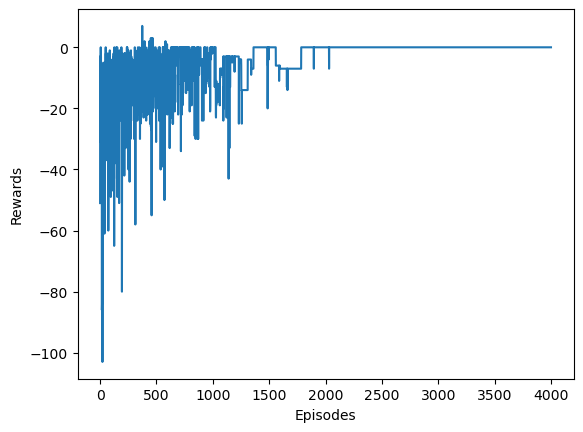

In [160]:
plt.plot(range(len(SARSA3_Rewards)),SARSA3_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

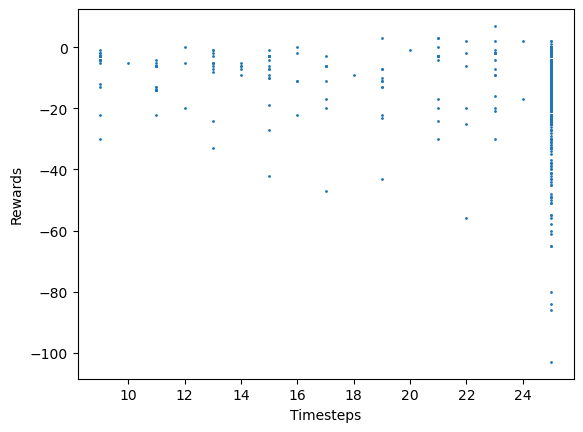

In [161]:
temp = sorted(zip(SARSA3_Rewards,SARSA3_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

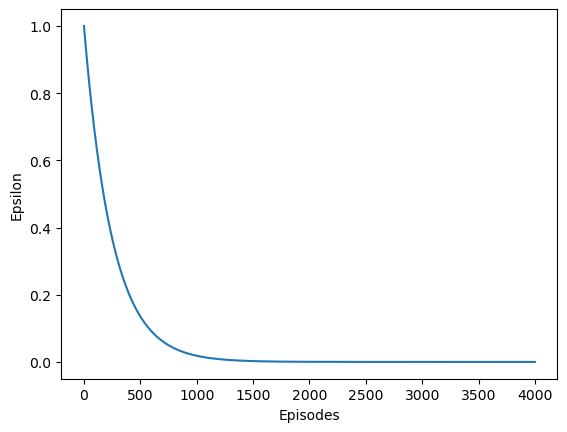

In [162]:
plt.plot(range(len(SARSA3_Epsilon)),SARSA3_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# Discount Factor 

# 1

In [163]:
episodes =4000
steps = 25
alpha = 0.1
discountFactor = 0.9
decayRate = 0.005
maxEpsilon = 1
minEpsilon = 0

In [164]:
SARSA4_QTable,SARSA4_Rewards,SARSA4_Epsilon,SARSA4_timesteps = SARSA(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(SARSA4_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.199810,-0.180512,-0.052071,0.808715,0.222350,5.314410,-0.015789,-0.100000,-0.1,0,...,-0.501556,-0.041798,-0.006078,-1.994801,-6.171415,-0.488414,-0.500354,-0.368290,-0.100000,-0.1
1,-0.109000,-0.190000,-0.059781,1.327267,0.377421,0.964802,-0.015824,-0.190000,-0.1,0,...,-1.793969,-1.349477,1.500946,-1.148583,-4.862939,-0.504847,-0.525824,-0.100000,-0.190000,-0.1
2,-0.198109,-0.008091,1.592600,4.304672,4.782969,0.476893,-0.271000,-0.100000,0.0,0,...,1.215767,1.350852,-0.618164,-10.587376,-0.975173,-0.956407,-0.523073,-0.271000,-0.100000,0.0
3,-0.288910,-0.280000,-0.662947,0.209264,1.338599,0.217245,2.806715,-0.000422,0.0,0,...,-0.313625,-0.076882,-0.406153,-0.141047,-0.919591,-1.942274,-0.538798,-0.327699,-0.118712,0.0


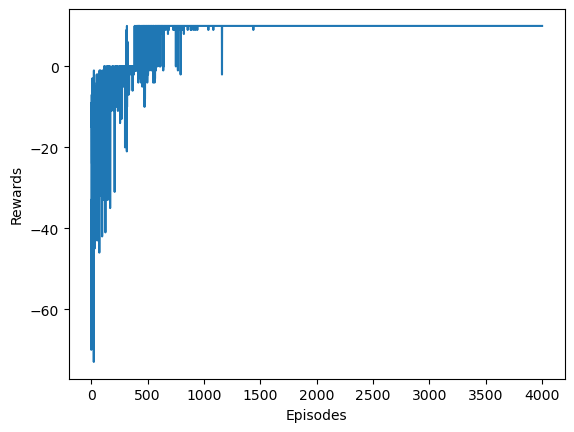

In [165]:
plt.plot(range(len(SARSA4_Rewards)),SARSA4_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

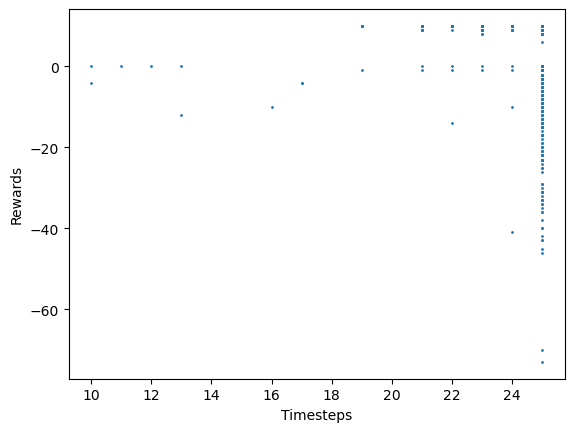

In [166]:
temp = sorted(zip(SARSA4_Rewards,SARSA4_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

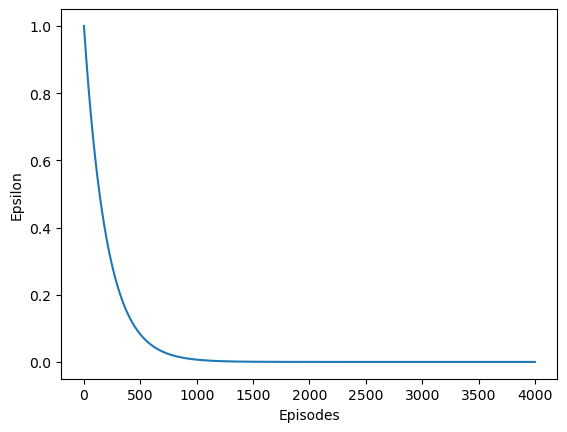

In [168]:
plt.plot(range(len(SARSA4_Epsilon)),SARSA4_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# 2

In [169]:
episodes =4000
steps = 25
alpha = 0.1
discountFactor = 0.8
decayRate = 0.004
maxEpsilon = 1
minEpsilon = 0

In [170]:
SARSA5_QTable,SARSA5_Rewards,SARSA5_Epsilon,SARSA5_timesteps = SARSA(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(SARSA5_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.1,0.0,-0.010224,-0.000967,0.000000,0.0,0.0,0,0,0,...,-6.826884e-02,-7.505924e-02,-0.529139,-1.196846,-4.238892,-1.205405,-0.389775,-0.19000,0.000,0.0
1,0.0,0.0,-0.000992,-0.000106,0.000000,0.0,0.0,0,0,0,...,-1.051858e+00,-1.041000e+00,-0.504568,-1.601699,-7.392450,-0.700699,-0.278776,-0.27820,-0.108,0.0
2,0.0,0.0,0.000000,-0.000029,0.000000,0.0,0.0,0,0,0,...,-9.339983e-199,-1.001474e-01,-1.397309,-11.364072,-1.420536,-0.629805,-0.351900,-0.10864,-0.100,-0.1
3,0.0,0.0,0.000000,-0.001216,-0.000131,0.0,0.0,0,0,0,...,-1.170462e-01,-9.466364e-199,-0.009124,-0.366986,-1.231661,-4.765993,-0.457598,-0.12168,0.000,-0.1


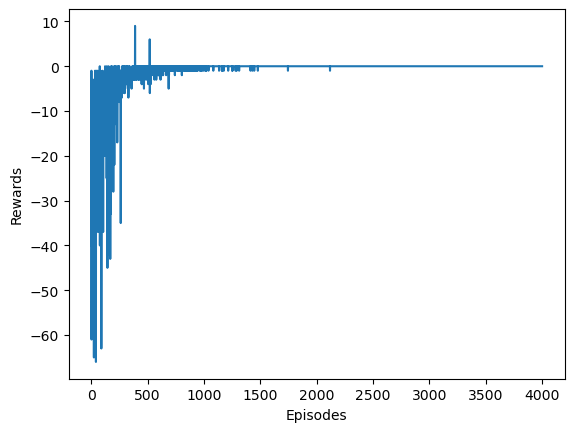

In [171]:
plt.plot(range(len(SARSA5_Rewards)),SARSA5_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

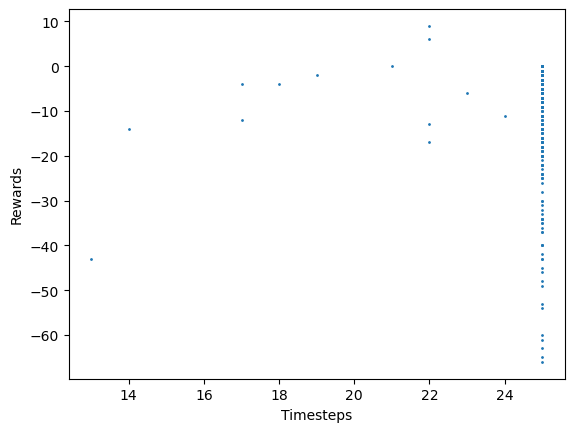

In [172]:
temp = sorted(zip(SARSA5_Rewards,SARSA5_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

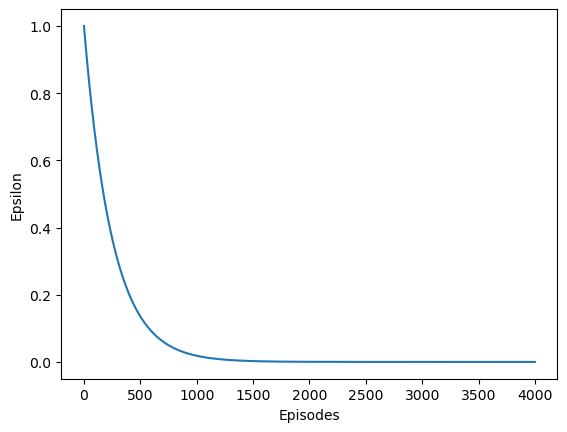

In [173]:
plt.plot(range(len(SARSA5_Epsilon)),SARSA5_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# 3

In [174]:
episodes =4000
steps = 25
alpha = 0.1
discountFactor = 0.75
decayRate = 0.004
maxEpsilon = 1
minEpsilon = 0

In [175]:
SARSA6_QTable,SARSA6_Rewards,SARSA6_Epsilon,SARSA6_timesteps = SARSA(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(SARSA6_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,0.0,-0.100000,-0.005550,-0.001095,-0.067500,-0.009619,0.0,0,0,0,...,-1.159943e-01,-8.131546e-02,-8.893182e-323,-2.198960,-7.390311,-1.147880,-0.679347,-0.474721,-0.285250,0.0
1,-0.1,-0.190000,-0.000506,-0.000289,-0.004556,-0.000721,0.0,0,0,0,...,-1.103033e+00,-1.115179e+00,-6.471516e-04,-1.138903,-3.674141,-1.092024,-0.703431,-0.365294,-0.204813,-0.1
2,0.0,-0.000012,-0.000159,-0.000591,0.000000,0.000000,0.0,0,0,0,...,-6.785173e-92,-4.200917e-94,-3.960932e-03,-11.260324,-1.542070,-1.068173,-0.690048,-0.358150,-0.100000,0.0
3,0.0,0.000000,-0.190000,-0.000464,0.000000,0.000000,0.0,0,0,0,...,-1.078438e-01,-6.506379e-02,-1.250466e-03,-0.001121,-1.384369,-4.075480,-0.649418,-0.343182,-0.107500,0.0


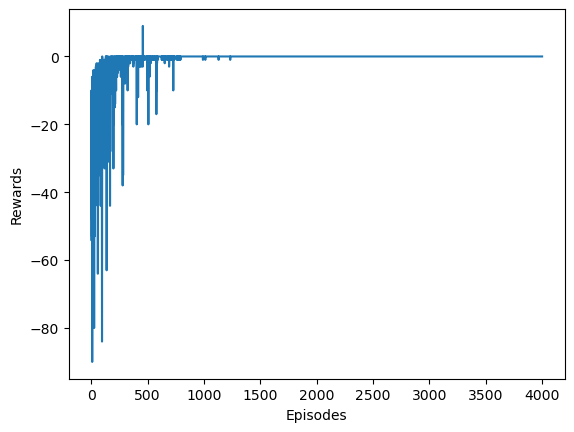

In [176]:
plt.plot(range(len(SARSA6_Rewards)),SARSA6_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

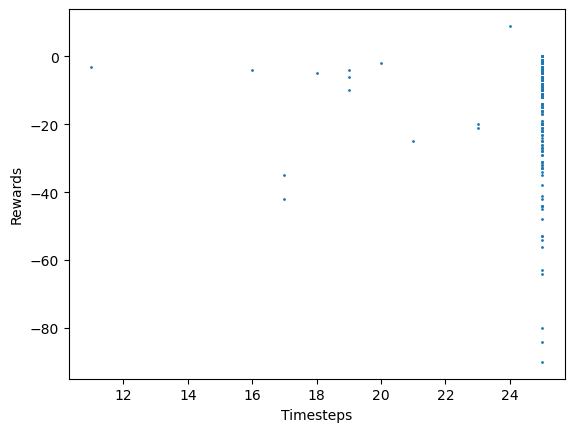

In [177]:
temp = sorted(zip(SARSA6_Rewards,SARSA6_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

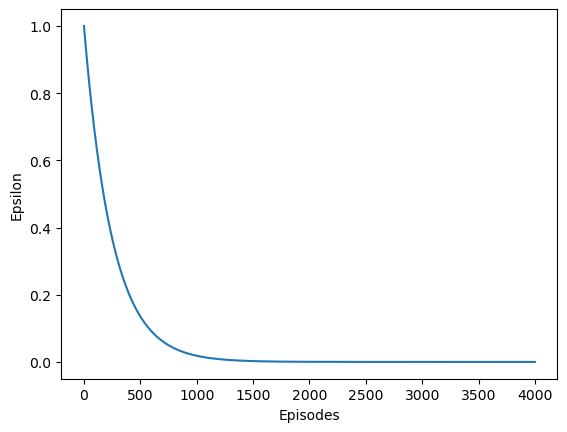

In [178]:
plt.plot(range(len(SARSA6_Epsilon)),SARSA6_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# Performing SARSA using Greedy option 

In [179]:
episodes =10
steps = 0
alpha = 0.1
discountFactor = 0.99
decayRate = 0.004
maxEpsilon = 1
minEpsilon = 0
SARSAgreed_QTable,SARSAgreed_Rewards,SARSAgreed_Epsilon,SARSAgreed_timesteps = SARSA(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate,True)
QTable_df(SARSAgreed_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.190000,-0.523414,-0.000794,-0.015084,-0.851143,-0.047818,-0.044239,-1.062877,-0.428834,-0.520173,...,-0.205942,-0.148544,-0.036217,-0.569335,-4.547420,-0.616076,-0.385324,-0.208810,-0.531872,-0.780863
1,-0.111762,-0.581925,0.000000,-0.002809,-0.000375,-0.052112,-0.185719,-0.856081,-0.897390,-0.393955,...,-1.009106,-1.054577,0.000000,-0.269216,-3.876763,-0.646353,-0.557013,-0.496667,-0.688508,-0.533814
2,-0.307571,-0.032034,-0.003393,-0.000692,-0.007620,-0.188956,-1.292268,-1.155367,-0.664126,-0.417977,...,-0.199853,-0.095086,-2.280293,-7.531366,-0.819683,-0.505955,-0.316109,-0.266919,-0.653272,-0.532305
3,-0.279910,-0.302355,-0.501160,-0.028479,0.000000,-0.129145,-0.015607,-0.165733,-0.982638,-0.420779,...,-0.121335,-0.027254,-0.070574,-0.346873,-0.324429,-4.477390,-0.864525,-0.441931,-0.385029,-0.680559


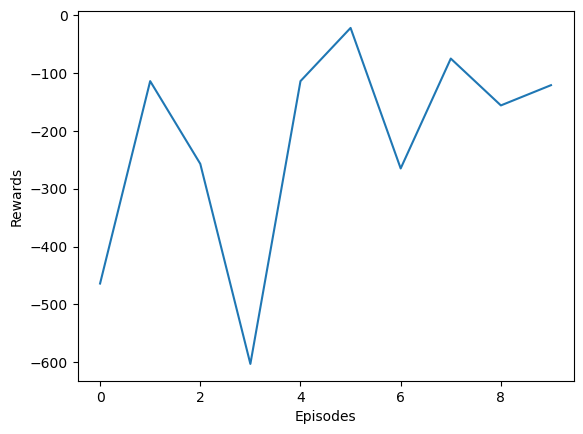

In [180]:
plt.plot(range(len(SARSAgreed_Rewards)),SARSAgreed_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

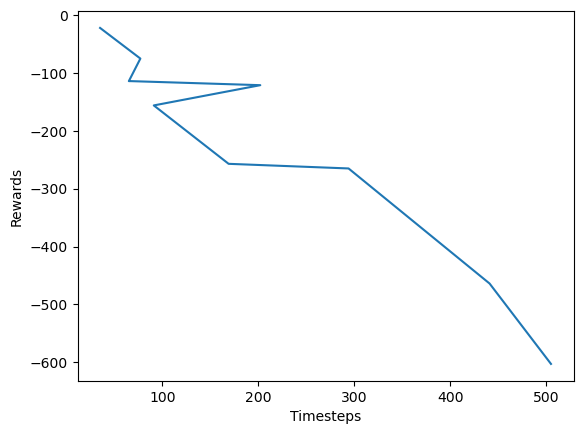

In [181]:
temp = sorted(zip(SARSAgreed_Rewards,SARSAgreed_timesteps),key= lambda k:k[0])
plt.plot([ele[1] for ele in temp],[ele[0] for ele in temp])
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

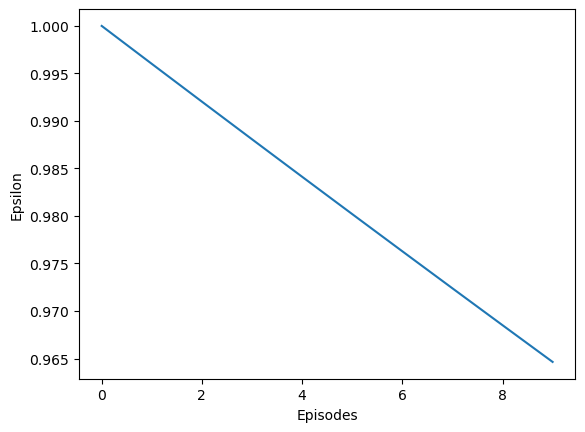

In [182]:
plt.plot(range(len(SARSAgreed_Epsilon)),SARSAgreed_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# Created QLearning function which Performs QLearning

In [184]:
def QLearning(total_episodes,Environment,Agent,minEpsilon,epsilon,Steps,alpha,discountFactor,decayRate,greedy = False):
  table =[[[0 for i in range(4)] for j in range(10)] for k in range(10)]
  rewards = []
  epsilons = []
  timesteps = []
  race = Environment()
  agent = Agent(race)
  for present_episode in range(1,total_episodes+1):
    reward = 0
    obs = race.reset()
    i = 0
    if greedy:
      action = agent.step(obs) if np.random.uniform(0,1) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
      while not all(race.agent_pos == np.array(race.goal_pos)):
        arg1 = race.agent_pos[0]
        arg2 = race.agent_pos[1]
        observation,reward_by_step = race.step(action)
        reward += reward_by_step
        action_next = agent.step(obs) if np.random.uniform(0,1) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
        table[arg1][arg2][action] += alpha * (reward_by_step +(discountFactor * (np.max(table[race.agent_pos[0]][race.agent_pos[1]])))- table[arg1][arg2][action])
        action = action_next
        i += 1
    else:
      action = agent.step(obs) if np.random.uniform(0,0.25) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
      for _ in range(Steps):
        arg1 = race.agent_pos[0]
        arg2 = race.agent_pos[1]
        observation,reward_by_step = race.step(action)
        reward += reward_by_step
        action_next = agent.step(obs) if np.random.uniform(0,0.25) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
        table[arg1][arg2][action] += alpha * (reward_by_step +(discountFactor * (np.max(table[race.agent_pos[0]][race.agent_pos[1]])))- table[arg1][arg2][action])      
        i += 1
        if all(race.agent_pos == np.array(race.goal_pos)):
          break
        action = action_next
    timesteps.append(i)
    epsilons.append(epsilon)
    epsilon = max(minEpsilon, (np.exp(-decayRate*present_episode)))
    rewards.append(reward)
  return table,rewards,epsilons,timesteps

# Hypertuning Alpha

# 1

In [185]:
episodes =15000
steps = 35
alpha = 0.001
discountFactor = 0.99
decayRate = 0.001
maxEpsilon = 1
minEpsilon = 0

In [186]:
QLearn1_QTable,QLearn1_Rewards,QLearn1_Epsilon,QLearn1_timesteps = QLearning(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(QLearn1_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.019039,-2.567759e-02,1.953952e-09,2.129502e-03,7.482200e-03,1.588201e-02,2.665321e-07,-1.999000e-03,-0.002001,-0.001000,...,3.335191e-10,1.618853e-07,3.166430e-06,2.567004e-20,-2.220753e+00,-0.171180,-0.086581,-0.045979,-0.031827,-0.018980
1,-0.018985,-1.882997e-02,6.114206e-18,3.892774e-09,2.872046e-10,5.018634e-08,4.329851e-13,-3.994004e-03,-0.001000,-0.001999,...,-8.892079e-01,-7.520920e-01,1.132043e+00,1.356414e-07,-2.087308e+00,-0.148982,-0.086167,-0.046659,-0.025871,-0.016941
2,-0.023726,3.170832e-15,4.660797e-18,8.371673e-13,4.281005e-07,3.060513e-10,-9.955120e-03,-1.000000e-03,-0.001000,-0.001000,...,4.422075e-01,7.233715e-01,6.979573e-11,-3.650615e+00,-2.381248e-01,-0.148660,-0.086849,-0.046489,-0.025873,-0.016999
3,-0.020933,-2.098789e-02,-1.784781e-02,1.841916e-15,1.211459e-08,2.841456e-09,2.208376e-12,4.237585e-12,-0.001999,-0.001000,...,4.779115e-09,9.466524e-09,5.053422e-09,1.183185e-19,3.613020e-21,-1.298325,-0.086330,-0.051779,-0.026228,-0.019014


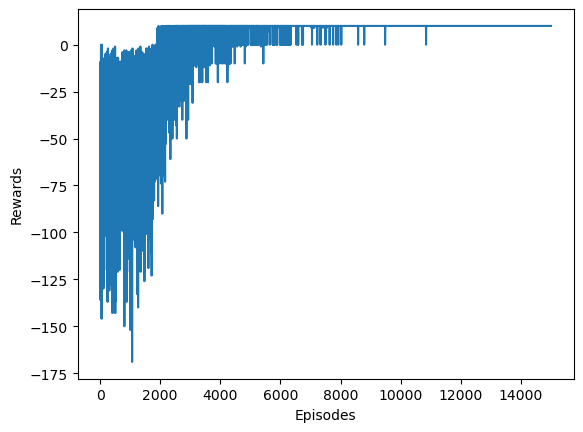

In [187]:
plt.plot(range(len(QLearn1_Rewards)),QLearn1_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

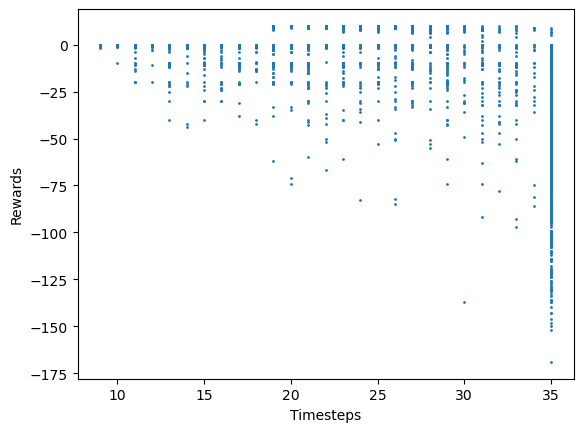

In [188]:
temp = sorted(zip(QLearn1_Rewards,QLearn1_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

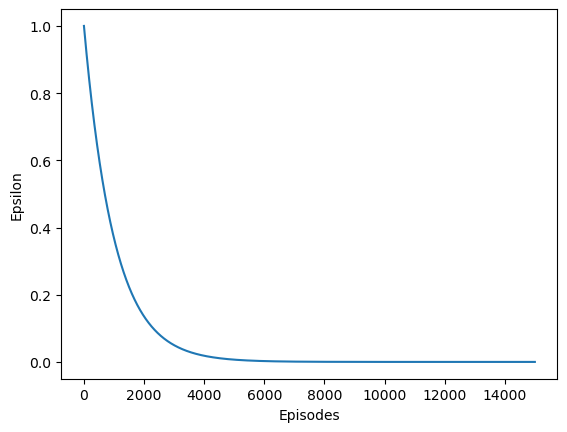

In [189]:
plt.plot(range(len(QLearn1_Epsilon)),QLearn1_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# 2

In [190]:
episodes =15000
steps = 35
alpha = 0.01
discountFactor = 0.99
decayRate = 0.001
maxEpsilon = 1
minEpsilon = 0

In [191]:
QLearn2_QTable,QLearn2_Rewards,QLearn2_Epsilon,QLearn2_timesteps = QLearning(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(QLearn2_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.309418,-1.983694e-01,0.017724,3.169099,3.374550,3.929346,0.011167,-1.000000e-02,-0.0199,-0.0199,...,1.170572,1.374461,1.287560,1.705438,-9.556272,-1.406127,-0.774060,-0.456257,-0.318768,-0.182778
1,-0.288566,-1.983694e-01,0.000014,0.008584,0.022872,0.097950,0.000005,-4.900995e-02,-0.0100,-0.0199,...,-0.911363,-0.943746,0.510362,8.600584,-9.526263,-0.687724,-0.351022,-0.408609,-0.217033,-0.208596
2,-0.282269,1.480349e-09,0.000237,0.040087,0.007144,0.000220,-0.077255,-2.970100e-02,-0.0199,-0.0100,...,8.345138,8.429432,8.514578,-9.765798,-1.715812,-1.107478,-0.704791,-0.392739,-0.265733,-0.202311
3,-0.287612,-2.768796e-01,-0.122479,0.000008,0.027272,0.023199,0.044805,8.480751e-08,-0.0199,-0.0100,...,1.477748,1.265187,1.469277,1.558530,1.769993,-7.785482,-0.985080,-0.486517,-0.304673,-0.208631


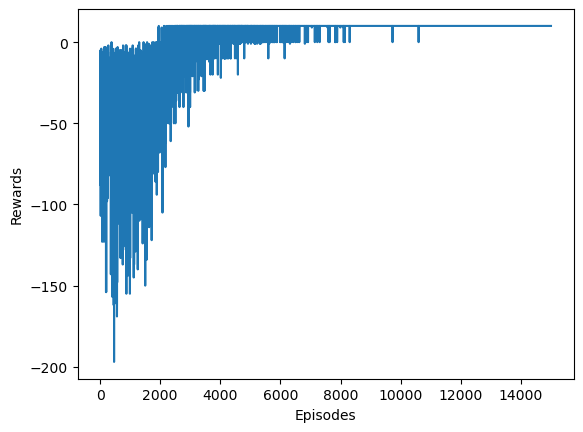

In [192]:
plt.plot(range(len(QLearn2_Rewards)),QLearn2_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

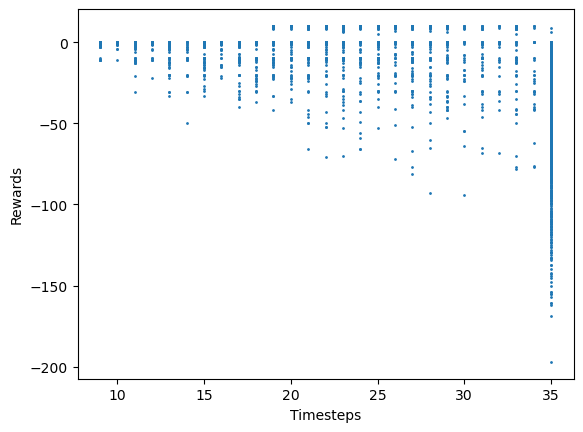

In [193]:
temp = sorted(zip(QLearn2_Rewards,QLearn2_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

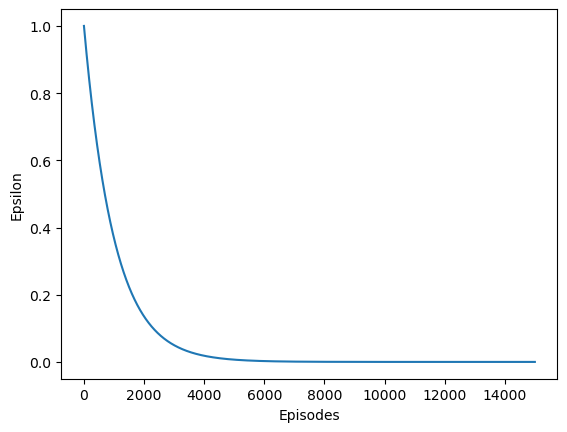

In [194]:
plt.plot(range(len(QLearn2_Epsilon)),QLearn2_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# 3

In [195]:
episodes =15000
steps = 35
alpha = 0.1
discountFactor = 0.99
decayRate = 0.001
maxEpsilon = 1
minEpsilon = 0

In [196]:
QLearn3_QTable,QLearn3_Rewards,QLearn3_Epsilon,QLearn3_timesteps = QLearning(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(QLearn3_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-1.519654,-0.855062,8.313981,9.227247,9.320537,9.414794,1.910134,-0.100000,0.00,-0.1,...,8.261686,8.345126,8.429425,5.933619,-3.517173,6.617068,5.336144,0.995397,-1.231817,-1.317795
1,-1.217862,-0.617054,1.233019,5.686119,5.171305,5.694315,0.646665,-0.189812,0.00,-0.1,...,7.178852,7.429419,8.514578,8.600554,-2.400796,7.712886,7.730253,2.745019,-0.555205,-1.022936
2,-0.589981,2.112226,3.765562,4.080767,7.208680,1.802866,-0.472515,-0.100000,-0.10,0.0,...,8.345138,8.429432,8.514158,-3.436411,6.635108,6.440709,3.175165,-1.364481,-1.329243,-1.058259
3,-1.085089,-1.266018,-0.827675,4.672129,3.717357,5.727971,6.307304,0.951076,-0.19,-0.1,...,8.261684,8.261675,8.345133,6.700584,2.167564,-3.479714,6.483600,5.612509,0.529189,-1.186200


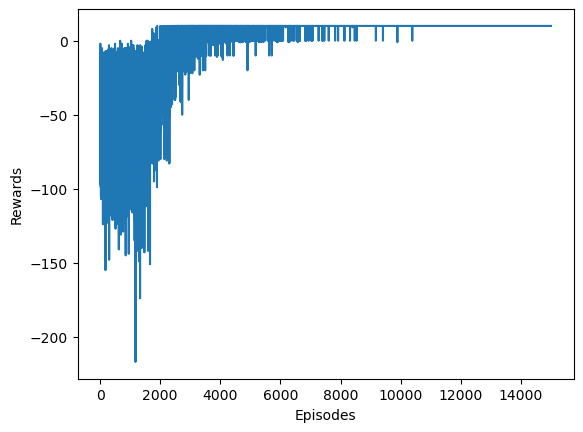

In [197]:
plt.plot(range(len(QLearn3_Rewards)),QLearn3_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

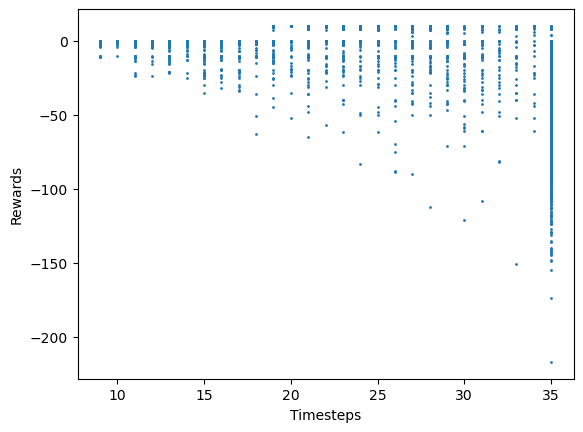

In [200]:
temp = sorted(zip(QLearn3_Rewards,QLearn3_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

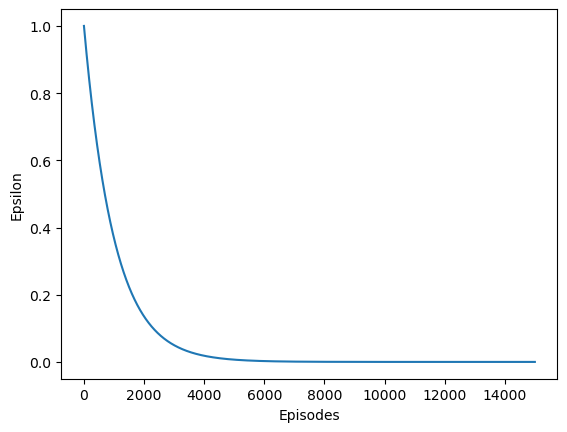

In [199]:
plt.plot(range(len(QLearn3_Epsilon)),QLearn3_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# HyperTuning Discount Factor

# 1

In [201]:
episodes =15000
steps = 35
alpha = 0.1
discountFactor = 0.8
decayRate = 0.001
maxEpsilon = 1
minEpsilon = 0

In [202]:
QLearn4_QTable,QLearn4_Rewards,QLearn4_Epsilon,QLearn4_timesteps = QLearning(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(QLearn3_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-1.519654,-0.855062,8.313981,9.227247,9.320537,9.414794,1.910134,-0.100000,0.00,-0.1,...,8.261686,8.345126,8.429425,5.933619,-3.517173,6.617068,5.336144,0.995397,-1.231817,-1.317795
1,-1.217862,-0.617054,1.233019,5.686119,5.171305,5.694315,0.646665,-0.189812,0.00,-0.1,...,7.178852,7.429419,8.514578,8.600554,-2.400796,7.712886,7.730253,2.745019,-0.555205,-1.022936
2,-0.589981,2.112226,3.765562,4.080767,7.208680,1.802866,-0.472515,-0.100000,-0.10,0.0,...,8.345138,8.429432,8.514158,-3.436411,6.635108,6.440709,3.175165,-1.364481,-1.329243,-1.058259
3,-1.085089,-1.266018,-0.827675,4.672129,3.717357,5.727971,6.307304,0.951076,-0.19,-0.1,...,8.261684,8.261675,8.345133,6.700584,2.167564,-3.479714,6.483600,5.612509,0.529189,-1.186200


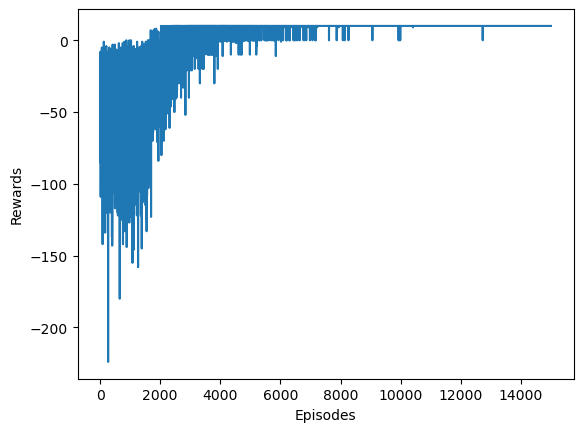

In [203]:
plt.plot(range(len(QLearn4_Rewards)),QLearn4_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

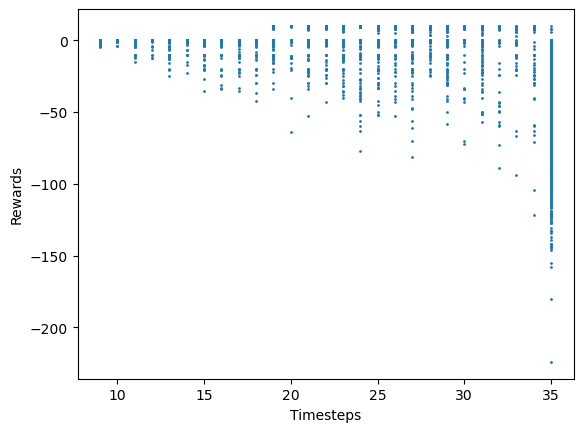

In [204]:
temp = sorted(zip(QLearn4_Rewards,QLearn4_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

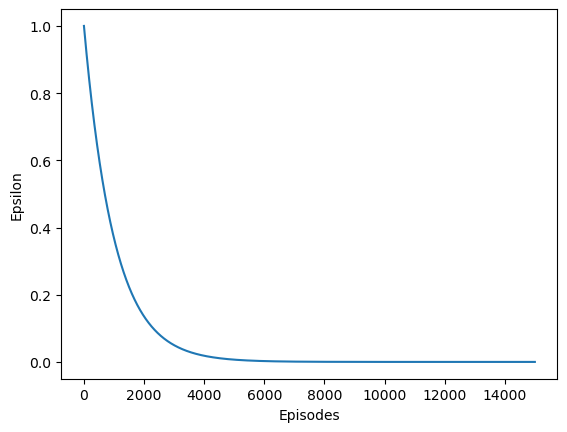

In [205]:
plt.plot(range(len(QLearn4_Epsilon)),QLearn4_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# 2

In [206]:
episodes =15000
steps = 35
alpha = 0.1
discountFactor = 0.75
decayRate = 0.001
maxEpsilon = 1
minEpsilon = 0

In [207]:
QLearn5_QTable,QLearn5_Rewards,QLearn5_Epsilon,QLearn5_timesteps = QLearning(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(QLearn5_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-1.544448,-0.928053,0.636934,1.001113,1.334826,1.779712,1.102221,-0.083730,-0.190000,-0.1900,...,0.042283,0.056377,0.075169,0.062536,-9.388119,0.835880,1.222461,-0.782438,-1.596097,-1.162762
1,-1.344410,-0.864914,0.086244,0.303707,0.566893,0.635637,0.019057,-0.271000,-0.190000,-0.2785,...,-0.968288,-0.924831,0.100226,0.133635,-8.158340,2.468575,3.658181,0.503141,-0.935450,-0.938509
2,-0.928209,0.095203,0.163845,0.518666,0.940451,0.282876,-0.463021,-0.351357,-0.197500,-0.1975,...,0.056377,0.075169,0.100225,-9.366057,0.849887,1.473157,-0.561702,-1.707065,-1.380493,-1.172147
3,-1.478858,-1.407550,-0.892917,0.240070,0.465278,0.529598,0.417087,0.035830,-0.186799,-0.1000,...,0.042283,0.042283,0.056377,0.064482,0.000831,-9.385126,0.779440,1.019803,-1.011586,-1.324629


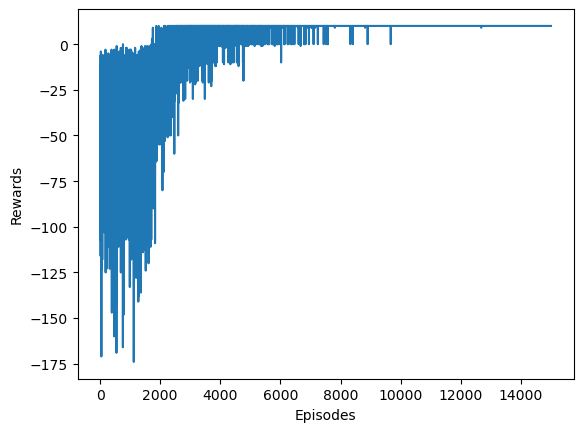

In [208]:
plt.plot(range(len(QLearn5_Rewards)),QLearn5_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

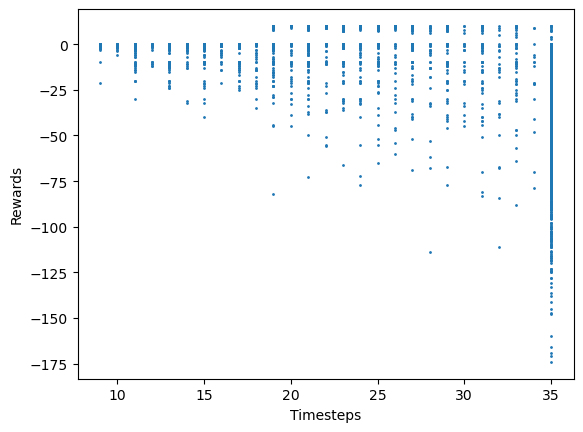

In [209]:
temp = sorted(zip(QLearn5_Rewards,QLearn5_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

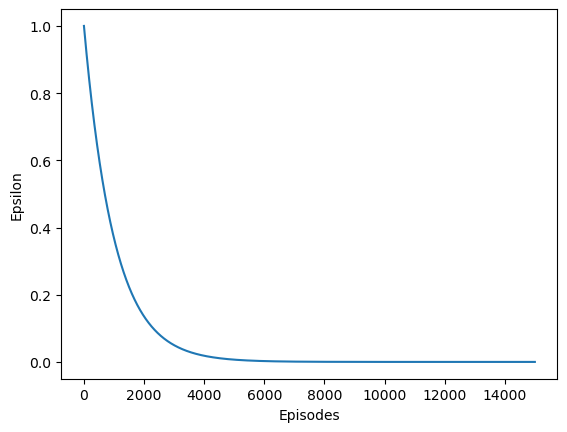

In [210]:
plt.plot(range(len(QLearn5_Epsilon)),QLearn5_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# 3

In [211]:
episodes =15000
steps = 35
alpha = 0.1
discountFactor = 0.50
decayRate = 0.001
maxEpsilon = 1
minEpsilon = 0

In [212]:
QLearn6_QTable,QLearn6_Rewards,QLearn6_Epsilon,QLearn6_timesteps = QLearning(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(QLearn6_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.908741,-0.849546,0.000549,0.039062,0.078121,0.156245,0.161711,-0.10000,-0.280974,-0.19950,...,0.000019,0.000038,0.000076,0.000138,-9.999997,-1.136003,-0.637507,-1.409298,-1.324420,-1.090739
1,-1.077379,-0.717570,0.001857,0.009288,0.019558,0.021781,0.001451,-0.34390,-0.195000,-0.19000,...,-0.999990,-0.999924,0.000153,0.000305,-9.999961,-0.250784,0.959946,-0.766543,-1.222338,-0.905390
2,-0.890581,0.001120,0.015751,0.020159,0.043458,0.027157,-0.569315,-0.34890,-0.353400,-0.40951,...,0.000038,0.000076,0.000153,-9.999970,-1.127829,-0.552099,-1.394604,-1.453245,-1.201598,-1.087745
3,-1.011325,-1.098900,-0.794052,0.003628,0.009632,0.017201,0.017599,0.00738,-0.100000,-0.19000,...,0.000019,0.000019,0.000038,0.000066,0.000125,-9.999981,-1.145645,-0.631923,-1.335819,-1.080631


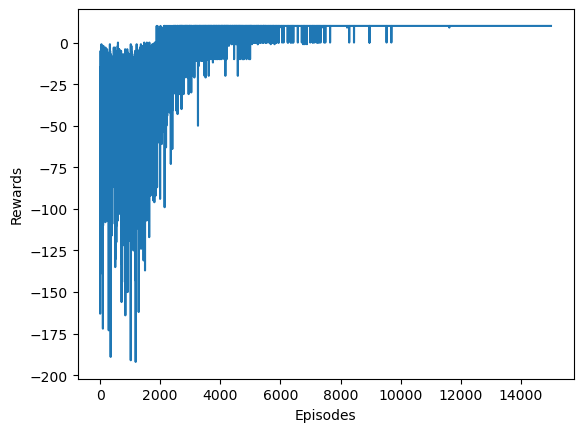

In [213]:
plt.plot(range(len(QLearn6_Rewards)),QLearn6_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

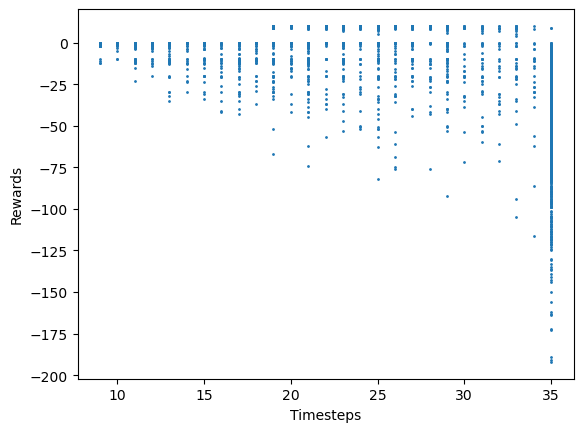

In [215]:
temp = sorted(zip(QLearn6_Rewards,QLearn6_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

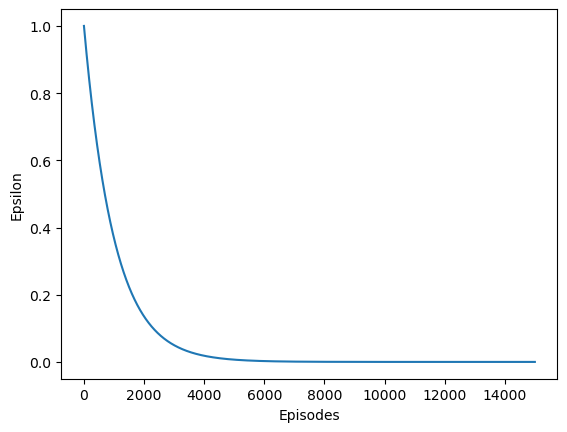

In [216]:
plt.plot(range(len(QLearn6_Epsilon)),QLearn6_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# Performing Greedy Option for QLearning

In [217]:
episodes =10
steps = 0
alpha = 0.1
discountFactor = 0.8
decayRate = 0.001
maxEpsilon = 1
minEpsilon = 0
QLearngreed_QTable,QLearngreed_Rewards,QLearngreed_Epsilon,QLearngreed_timesteps = QLearning(episodes,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate,True)
QTable_df(QLearngreed_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,-0.579117,-0.745813,0.000000,0.0,0.0,0.0,0.00,-0.468559,-0.100000,-0.680534,...,0.000000,0.000000,0.0,0.000000,-4.095100,-0.42471,-0.381103,-0.343900,-0.388159,-0.566884
1,-0.704232,-0.833228,0.000000,0.0,0.0,0.0,0.00,-0.569533,-0.100000,-0.294040,...,-0.901523,-0.911371,0.0,0.000000,-5.217031,-0.19800,-0.249877,-0.543117,-0.524892,-1.017512
2,-0.612580,0.000000,0.000000,0.0,0.0,0.0,-0.19,-0.190000,-0.279000,-0.492082,...,0.000000,0.000000,0.0,-5.695328,-0.438390,-0.27900,-0.553746,-0.654801,-0.764450,-0.444862
3,-0.619100,-0.727188,-0.745813,0.0,0.0,0.0,0.00,0.000000,-0.468559,-0.417510,...,0.000000,0.000000,0.0,0.000000,0.000000,-3.43900,-0.205840,-0.379879,-0.506748,-0.544694


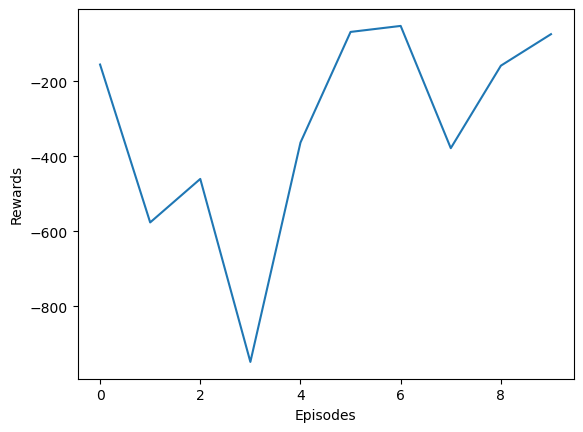

In [218]:
plt.plot(range(len(QLearngreed_Rewards)),QLearngreed_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

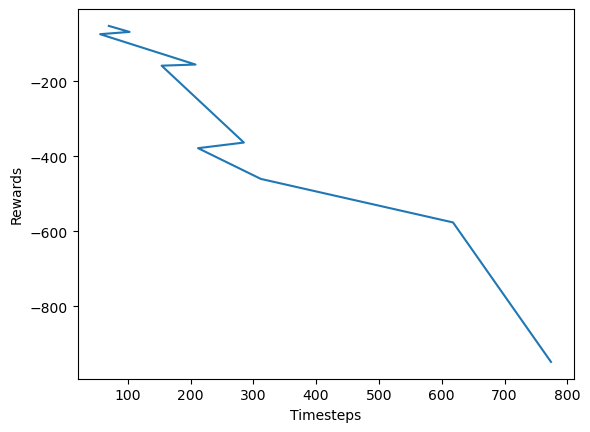

In [219]:
temp = sorted(zip(QLearngreed_Rewards,QLearngreed_timesteps),key= lambda k:k[0])
plt.plot([ele[1] for ele in temp],[ele[0] for ele in temp])
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

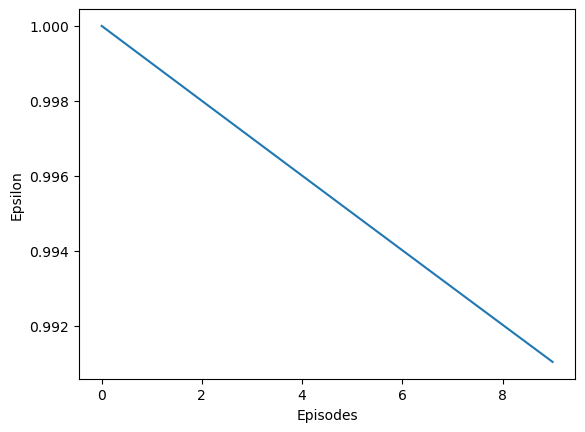

In [220]:
plt.plot(range(len(QLearngreed_Epsilon)),QLearngreed_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

# Comparing Best Selection for both SARSA and QLearning

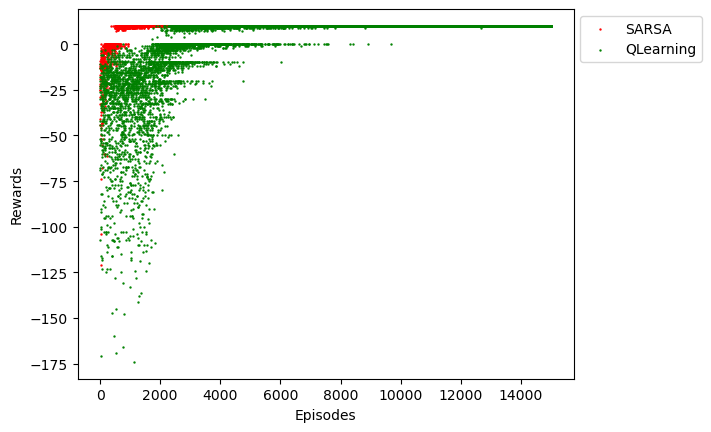

In [221]:
plt.scatter(range(len(SARSA1_Rewards)),SARSA1_Rewards,s= 0.5, color = 'red')
plt.scatter(range(len(QLearn5_Rewards)),QLearn5_Rewards,s= 0.5,color = 'green')
plt.legend(['SARSA','QLearning'],loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

# BONUS

# N-STEP SARSA (2-STEP)

In [222]:
def NStepSARSA(total_episodes,Step,Environment,Agent,minEpsilon,epsilon,Steps,alpha,discountFactor,decayRate,greedy = False):
  table =[[[0 for i in range(4)] for j in range(10)] for k in range(10)]
  rewards = []
  epsilons = []
  timesteps = []
  race = Environment()
  agent = Agent(race)
  for present_episode in range(1,total_episodes+1):
    reward = 0
    obs = race.reset()
    action = agent.step(obs) if np.random.uniform(0,0.25) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
    if greedy:
      i = 0
      j = 1
      q_update_value = 0
      while not all(race.agent_pos == np.array(race.goal_pos)):
        if j == 1:
          arg1 = race.agent_pos[0]
          arg2 = race.agent_pos[1]
          main_action = action
        observation,reward_by_step = race.step(action)
        reward += reward_by_step
        action_next = agent.step(obs) if np.random.uniform(0,0.25) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
        q_update_value += reward_by_step + ((discountFactor ** j) * (table[race.agent_pos[0]][race.agent_pos[1]][action_next]))
        if j == Step:
          table[arg1][arg2][main_action] += alpha * (q_update_value - table[arg1][arg2][main_action])
          q_update_value = 0
          j=1
          continue
        j += 1
        action = action_next
        i += 1
      timesteps.append(i)
    else:
      i = 0
      j=1
      q_update_value = 0
      for _ in range(Steps):
        if j == 1:
          arg1 = race.agent_pos[0]
          arg2 = race.agent_pos[1]
          main_action = action
        observation,reward_by_step = race.step(action)
        reward += reward_by_step
        action_next = agent.step(obs) if np.random.uniform(0,0.25) < epsilon else np.argmax(table[race.agent_pos[0]][race.agent_pos[1]])
        q_update_value += reward_by_step + (discountFactor ** j) * (table[race.agent_pos[0]][race.agent_pos[1]][action_next])
        if j == Step: 
          table[arg1][arg2][main_action] += alpha * (q_update_value - table[arg1][arg2][main_action])
          j = 1
          q_update_value = 0
          if all(race.agent_pos == np.array(race.goal_pos)):
            break
          continue
        i += 1
        j += 1
        if all(race.agent_pos == np.array(race.goal_pos)):
          break
        action = action_next
      timesteps.append(i)
    epsilons.append(epsilon)
    epsilon = max(minEpsilon, (np.exp(-decayRate*present_episode)))
    rewards.append(reward)
  return table,rewards,epsilons,timesteps

In [266]:
episodes =5000
steps = 25
alpha = 0.1
discountFactor = 0.95
decayRate = 0.005
maxEpsilon = 1
minEpsilon = 0

In [267]:
NSARSA_QTable,NSARSA_Rewards,NSARSA_Epsilon,NSARSA_timesteps = NStepSARSA(episodes,2,RaceEnv,CarAgent,minEpsilon,maxEpsilon,steps,alpha,discountFactor,decayRate)
QTable_df(NSARSA_QTable)

,"State (0,0)","State (0,1)","State (0,2)","State (0,3)","State (0,4)","State (0,5)","State (0,6)","State (0,7)","State (0,8)","State (0,9)",...,"State (9,0)","State (9,1)","State (9,2)","State (9,3)","State (9,4)","State (9,5)","State (9,6)","State (9,7)","State (9,8)","State (9,9)"
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.00,0,...,-21.698965,-9.439476,-16.280736,-14.691496,-29.744309,-12.266485,-6.042374,-1.343573,-1.225332,-0.999258
1,-1.330655,-0.117017,-0.184628,0.0,0.0,0.0,0.0,0.000,-0.38,0,...,-26.273055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,-0.296376,0.000000,0.0,0.0,0.0,0.0,-0.219,0.00,0,...,-7.915663,-0.611768,-4.612876,-30.012853,-10.621862,-6.690596,-3.456085,-2.182273,-0.436553,-1.243053
3,-0.542000,-0.542000,-0.200000,0.0,0.0,0.0,0.0,-0.100,0.00,0,...,-17.277467,-118.686220,-60.284038,-27.859519,-13.654748,-27.206426,-10.555789,-1.650066,-1.416958,0.000000


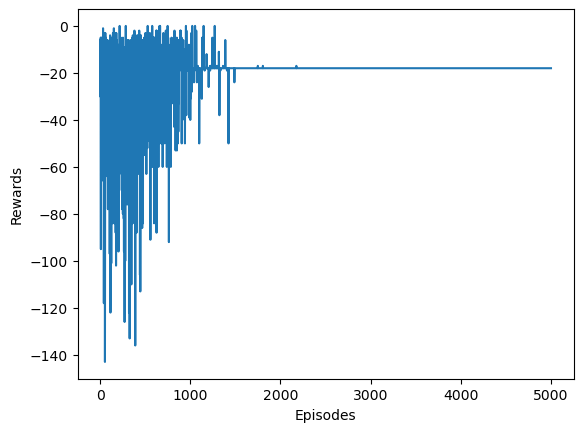

In [269]:
plt.plot(range(len(NSARSA_Rewards)),NSARSA_Rewards)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

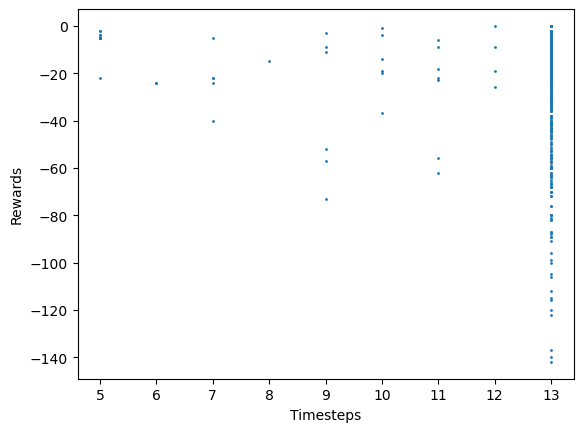

In [260]:
temp = sorted(zip(NSARSA_Rewards,NSARSA_timesteps),key= lambda k:k[0])
plt.scatter([ele[1] for ele in temp],[ele[0] for ele in temp],s=1)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.show()

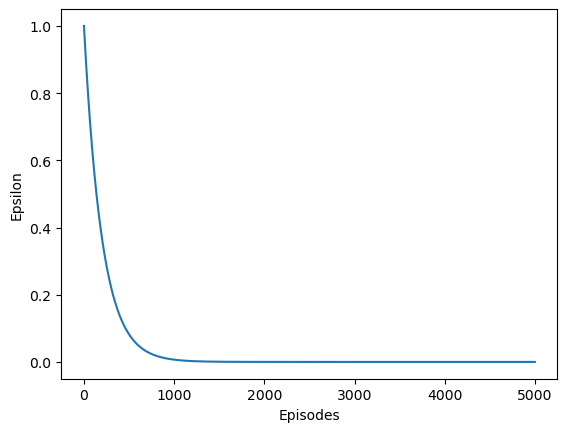

In [261]:
plt.plot(range(len(NSARSA_Rewards)),NSARSA_Epsilon)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

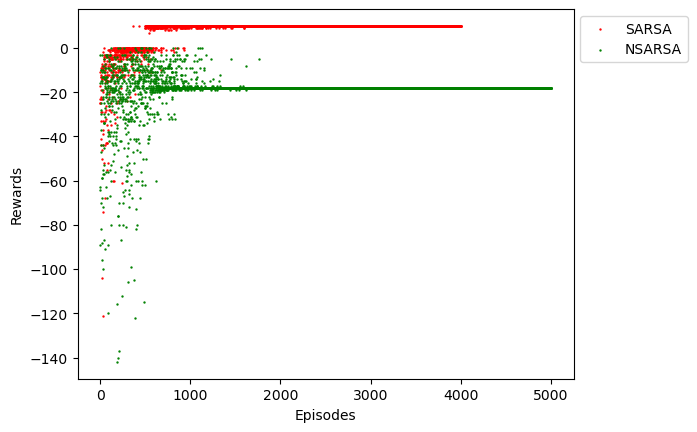

In [262]:
plt.scatter(range(len(SARSA1_Rewards)),SARSA1_Rewards,s= 0.5, color = 'red')
plt.scatter(range(len(NSARSA_Rewards)),NSARSA_Rewards,s= 0.5,color = 'green')
plt.legend(['SARSA','NSARSA'],loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()